In [31]:
#####################################################################################################
### Task b, OLS regression of Franke function

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import resample
#np.random.seed(2019) #set seed for troubleshooting (same random outputs every run)

# Functions from task description
def R2(y_data, y_model): #score function
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)
def MSE(y_data,y_model): #mean square error
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

# From lecture notes on Ridge/Lasso regression (4.8)
def create_X(x, y, n): 
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n+1)*(n+2)/2) # Number of elements in beta
    X = np.ones((N,l))

    for i in range(1,n+1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = (x**(i-k))*(y**k)
    return X

In [32]:
# Making meshgrid of random datapoints and computing Franke's function
N = 40
x = np.sort(np.random.uniform(0, 1, N))
y = np.sort(np.random.uniform(0, 1, N))

x_, y_ = np.meshgrid(x,y)

var = 0.1 # Variance of noise 
noise = np.random.normal(0, var, len(x_)*len(x_)) 
noise = noise.reshape(len(x_), len(x_))

z = FrankeFunction(x_, y_) + noise #Franke with added noise

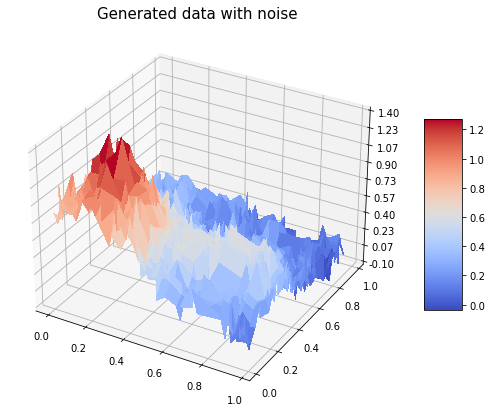

In [33]:
# Plotting the generated data 'z'
fig = plt.figure(figsize = (13, 7)) 
ax = fig.add_subplot(projection='3d') #

surf = ax.plot_surface(x_, y_, z, cmap = cm.coolwarm,
linewidth = 0, antialiased = False)

ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('Generated data with noise', fontsize = 15)
plt.show()

In [34]:
# Calculating an example beta via OLS SVD method

n = 5 # Regression polynomial degree (this affects the approximate terrain plot below)
X = create_X(x_, y_, n) # Construct design matrix

# We split the data in training (80%) and test (20%) data
X_train, X_test, z_train, z_test = train_test_split(X, np.ravel(z), test_size=0.2)

# Matrix inversion to find beta, OLS method
beta = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ z_train
print(f'{len(beta)} beta features: \n', beta)

21 beta features: 
 [  0.51053887   7.22331592   2.86105973 -32.09861332 -13.80758466
  -5.42889288  43.81189408  40.51832257  20.63581303 -13.03527887
 -18.57414579 -49.80535828  -6.25383778 -30.46158049  32.60222197
  -0.94335675  19.38736165   6.6811065   -2.92018813  16.56488238
 -17.39486914]


In [35]:
# Model and prediction

ztilde = X_train @ beta
print("Training R2")
print(R2(z_train, ztilde))
print("Training MSE")
print(MSE(z_train, ztilde))

zpredict = X_test @ beta
print("Test R2")
print(R2(z_test, zpredict))
print("Test MSE")
print(MSE(z_test, zpredict))

Training R2
0.8584385027943482
Training MSE
0.011821468936823397
Test R2
0.8616039816102141
Test MSE
0.011452958763441153


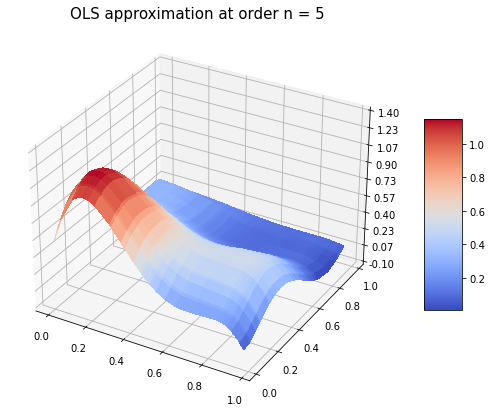

In [36]:
# Scikit regression for plot 
linreg = LinearRegression()
linreg.fit(X, np.ravel(z))

zmatrix = linreg.predict(X)
z_matrix = zmatrix.reshape((N, N))

# Ploting surface
fig = plt.figure(figsize = (13, 7))
ax = fig.add_subplot(projection='3d') #

surf = ax.plot_surface(x_, y_, z_matrix, cmap = cm.coolwarm,
linewidth = 0, antialiased = False)

ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title(f'OLS approximation at order n = {n}', fontsize = 15)
plt.show()

In [37]:
### OLS Analysis as function of polynomial degree n

n = 13
MSE_train = np.zeros(n)
R2_train = np.zeros(n)
MSE_test = np.zeros(n)
R2_test = np.zeros(n)
var_B_train = np.zeros(n)
var_B_test = np.zeros(n)
N_ = np.array([b+1 for b in range(n)])
for i in range(0, n): #variables marked to avoid confusion with older
    X_ = create_X(x_, y_, i+1)
    # 'random-state'; same division every iteration
    X_train_, X_test_, z_train_, z_test_ = train_test_split(X_, np.ravel(z), test_size=0.2, random_state = 40)
    beta_ = np.linalg.pinv(X_train_.T @ X_train_) @ X_train_.T @ z_train_
    ztilde_ = X_train_ @ beta_
    zpredict_ = X_test_ @ beta_
    MSE_train[i] = (MSE(z_train_, ztilde_))
    R2_train[i] = (R2(z_train_, ztilde_))
    MSE_test[i] = (MSE(z_test_, zpredict_))
    R2_test[i] = (R2(z_test_, zpredict_))
    #something's wrong here, (X^T X)^-1 does not become a scalar
    #var_B_train[i] = var*np.linalg.pinv(X_train_.T @ X_train_) #from task a
    #var_B_test[i] = var*np.linalg.pinv(X_test_.T @ X_test_)
    var_B_train[i] = np.var(beta_) #is this sufficient?

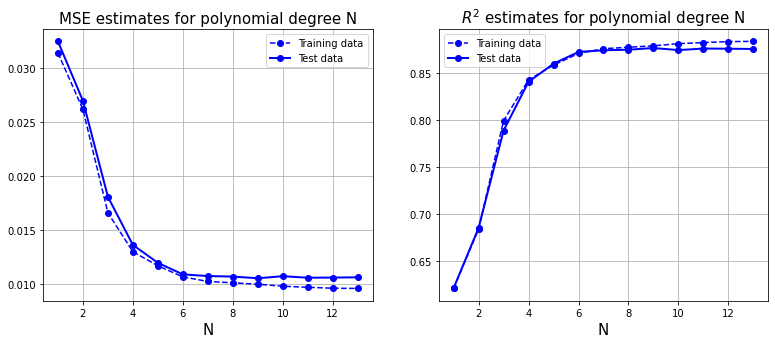

In [38]:
# Plotting MSE and R2 as function of polynomial degree

fig = plt.figure(figsize = (13, 5)) 
plt.subplot(1, 2, 1)
plt.title('MSE estimates for polynomial degree N', fontsize = 15)
plt.plot(N_, MSE_train, 'b--', marker = 'o', label = 'Training data')
plt.plot(N_, MSE_test, 'b', marker = 'o', label = 'Test data', linewidth = 2)
plt.xlabel('N', fontsize = 15)
plt.grid(1); plt.legend()

plt.subplot(1, 2, 2)
plt.title('$R^2$ estimates for polynomial degree N', fontsize = 15)
plt.plot(N_, R2_train, 'b--', marker = 'o', label = 'Training data')
plt.plot(N_, R2_test, 'b', marker = 'o', label = 'Test data', linewidth = 2)
plt.xlabel('N', fontsize = 15)
plt.grid(1); plt.legend(); plt.show()

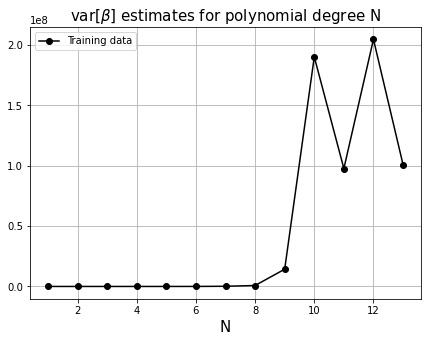

Variance of betas for n = 1 to 13: [0.5564, 0.5778, 9.284, 107.9, 548.1, 9989.0, 143100.0, 779200.0, 14280000.0, 190100000.0, 97640000.0, 204700000.0, 100900000.0]


In [39]:
# Plotting var(beta) as function of polynomial degree

fig = plt.figure(figsize = (7, 5))
plt.title('var[$\\beta$] estimates for polynomial degree N', fontsize = 15)
plt.plot(N_, var_B_train, 'k', marker = 'o', label = 'Training data')
#plt.plot(N_, var_B_test, 'b', marker = 'o', label = 'Test data', linewidth = 2)
plt.xlabel('N', fontsize = 15)
plt.grid(1); plt.legend(); plt.show()

varb = [eval(f'{v:.4}') for v in var_B_train]
print(f'Variance of betas for n = 1 to {n}: {varb}')

Are these values reasonable? Considering that the amount of beta-values/features increase with polynomial degree (more parameters to adjust/more degrees of freedom) it is expected that the variance increases, but what do these values tell us? (confidence intervals...)

In [40]:
#####################################################################################################
## Task c, lect notes (5.4) expanded to 3d
## Bootstrap assisted regression using scikit.learn functions

n_boostraps = 100
maxdegree = n

error = np.zeros(maxdegree)
bias = np.zeros(maxdegree)
variance = np.zeros(maxdegree)
polydegree = np.zeros(maxdegree)

model = LinearRegression() #instance of linreg class

# Resample X and z a set amount of times, every degree n
for degree in range(maxdegree):
    X_ = create_X(x_, y_, degree+1)
    X_train_, X_test_, z_train_, z_test_ = train_test_split(X_, z.ravel(), test_size=0.2, random_state = 40)
    z_pred = np.empty((z_test_.shape[0], n_boostraps))
    for i in range(n_boostraps): #how to do this in 3d?
        X_, z_ = resample(X_train_, z_train_)
        z_pred[:, i] = model.fit(X_, z_).predict(X_test_).ravel() 

    polydegree[degree] = degree

    error[degree] = np.mean( np.mean((z_test_.reshape(-1, 1) - z_pred)**2, axis=1, keepdims=True) )
    bias[degree] = np.mean( (z_test_.reshape(-1, 1) - np.mean(z_pred, axis=1, keepdims=True))**2 )
    variance[degree] = np.mean( np.var(z_pred, axis=1, keepdims=True) )

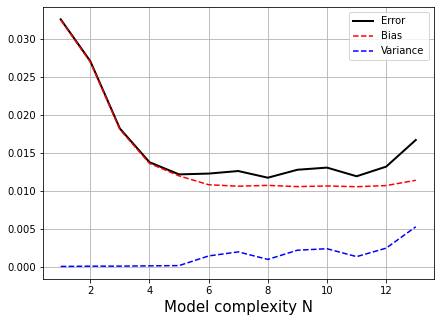

In [41]:
# Error, bias, variance plotted as function of complexity

fig = plt.figure(figsize = (7, 5)) 
plt.plot(N_, error, 'k', label='Error', linewidth = 2)
plt.plot(N_, bias, 'r--', label='Bias', linewidth = 1.5)
plt.plot(N_, variance, 'b--', label='Variance', linewidth = 1.5)
plt.xlabel('Model complexity N', fontsize = 15)
plt.legend(); plt.grid(1); plt.show()

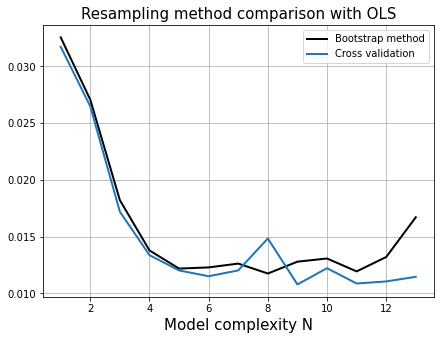

In [42]:
#####################################################################################################
### Task d, lect notes (5.5) expanded to 3d
### Cross-validation assisted regression using scikit functions

from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

## Cross-validation on OLS regression using KFold only

# Initialize a KFold instance
k = 10
kfold = KFold(n_splits = k, shuffle = True)

# Perform the cross-validation to estimate MSE
scores_KFold = np.zeros((maxdegree, k))
model = LinearRegression()

# Resample X and z a set amount of times, every degree n
N_ = np.array([b+1 for b in range(maxdegree)])
for i in range(maxdegree):
    X_ = create_X(x_, y_, i+1)
    j = 0
    for train_inds, test_inds in kfold.split(X_):
        Xtrain = X_[train_inds]
        ztrain = z.ravel()[train_inds]

        Xtest = X_[test_inds]
        ztest = z.ravel()[test_inds]

        zpred = model.fit(Xtrain, ztrain).predict(Xtest).ravel()
        scores_KFold[i, j] = np.mean((zpred.flatten() - ztest.flatten())**2)
        
        j += 1

estimated_mse_KFold = np.mean(scores_KFold, axis = 1)

fig = plt.figure(figsize = (7, 5)) 
plt.title('Resampling method comparison with OLS', fontsize = 15)
plt.plot(N_, error, 'k', label='Bootstrap method', linewidth = 2)
plt.plot(N_, estimated_mse_KFold, label = 'Cross validation', linewidth = 2)
plt.xlabel('Model complexity N', fontsize = 15)
plt.grid(1); plt.legend(); plt.show()